(AR)=
# Analysis of An $AR(1)$ Model in PyMC
:::{post} Jan 7, 2023
:tags: time series, autoregressive 
:category: intermediate,
:author: Ed Herbst, Chris Fonnesbeck
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Consider the following AR(2) process, initialized in the
infinite past:
$$
   y_t = \rho_0 + \rho_1 y_{t-1} + \rho_2 y_{t-2} + \epsilon_t,
$$
where $\epsilon_t \overset{iid}{\sim} {\cal N}(0,1)$.  Suppose you'd like to learn about $\rho$ from a a sample of observations $Y^T = \{ y_0, y_1,\ldots, y_T \}$.

First, let's generate some synthetic sample data. We simulate the 'infinite past' by generating 10,000 samples from an AR(2) process and then discarding the first 5,000:

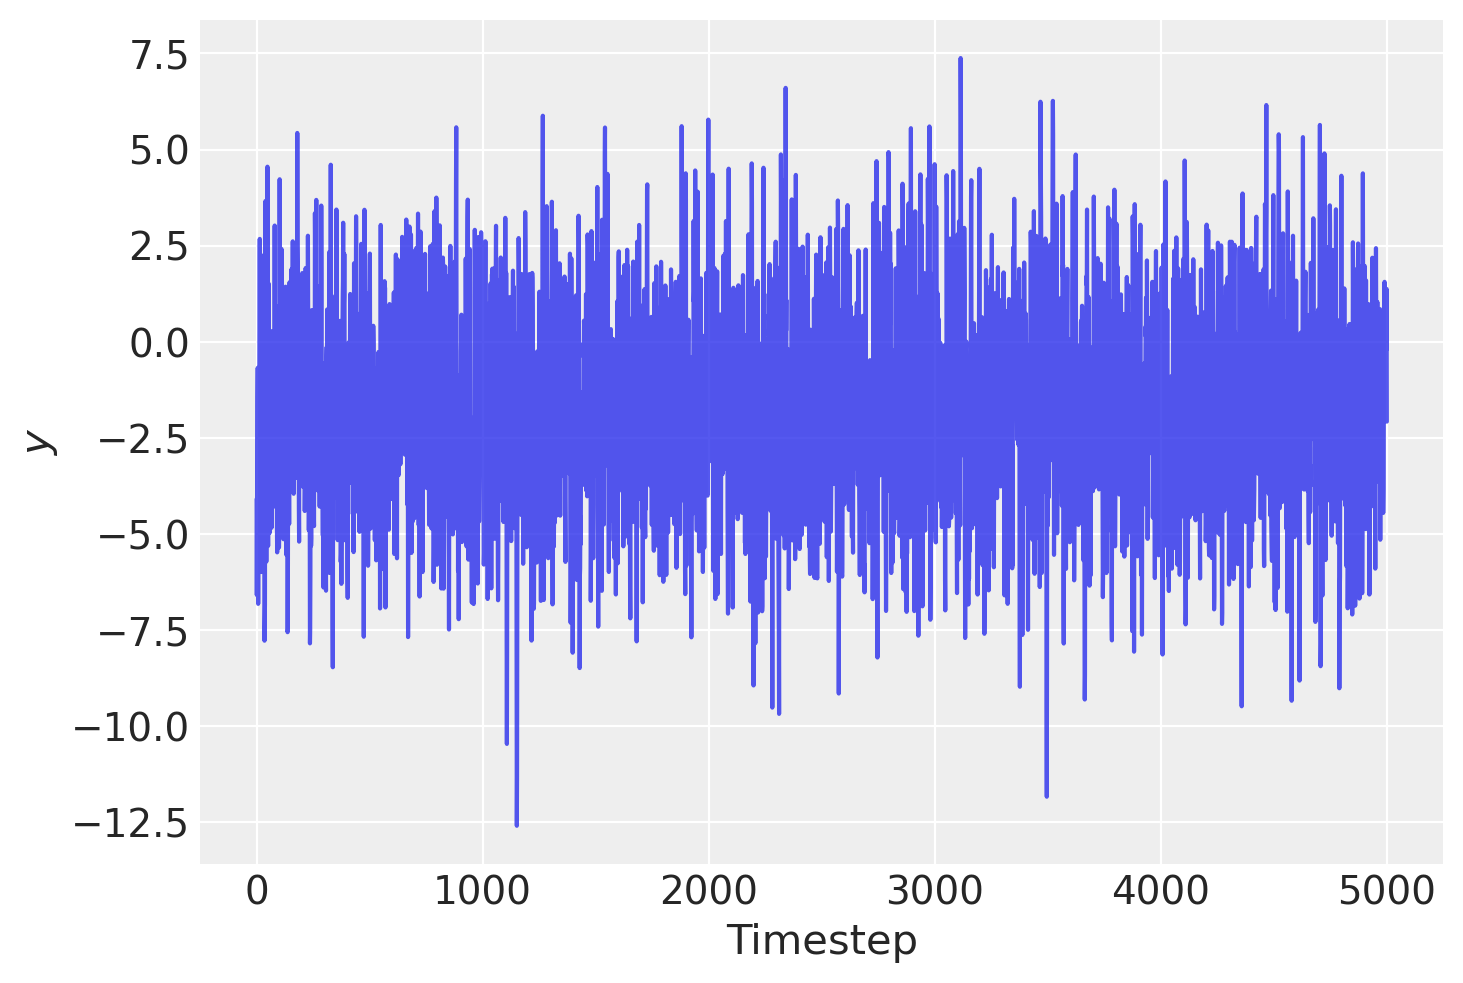

In [3]:
T = 10000

# true stationarity:
true_rho = 0.7, -0.3
# true standard deviation of the innovation:
true_sigma = 2.0
# true process mean:
true_center = -1.0

y = np.random.normal(loc=true_center, scale=true_sigma, size=T)
y[1] += true_rho[0] * y[0]
for t in range(2, T - 100):
    y[t] += true_rho[0] * y[t - 1] + true_rho[1] * y[t - 2]

y = y[-5000:]
plt.plot(y, alpha=0.8)
plt.xlabel("Timestep")
plt.ylabel("$y$");

Let's start by trying to fit the wrong model! Assume that we do no know the generative model and so simply fit an AR(1) model for simplicity.

This generative process is quite straight forward to implement in PyMC. Since we wish to include an intercept term in the AR process, we must set `constant=True` otherwise PyMC will assume that we want an AR2 process when `rho` is of size 2. Also, by default a $N(0, 100)$ distribution will be used as the prior for the initial value. We can override this by passing a distribution (not a full RV) to the `init_dist` argument.

In [4]:
with pm.Model() as ar1:
    # assumes 95% of prob mass is between -2 and 2
    rho = pm.Normal("rho", mu=0.0, sigma=1.0, shape=2)
    # precision of the innovation term
    tau = pm.Exponential("tau", lam=0.5)

    likelihood = pm.AR(
        "y", rho=rho, tau=tau, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, tau]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 5 seconds.


We can see that even though we assumed the wrong model, the parameter estimates are actually not that far from the true values.

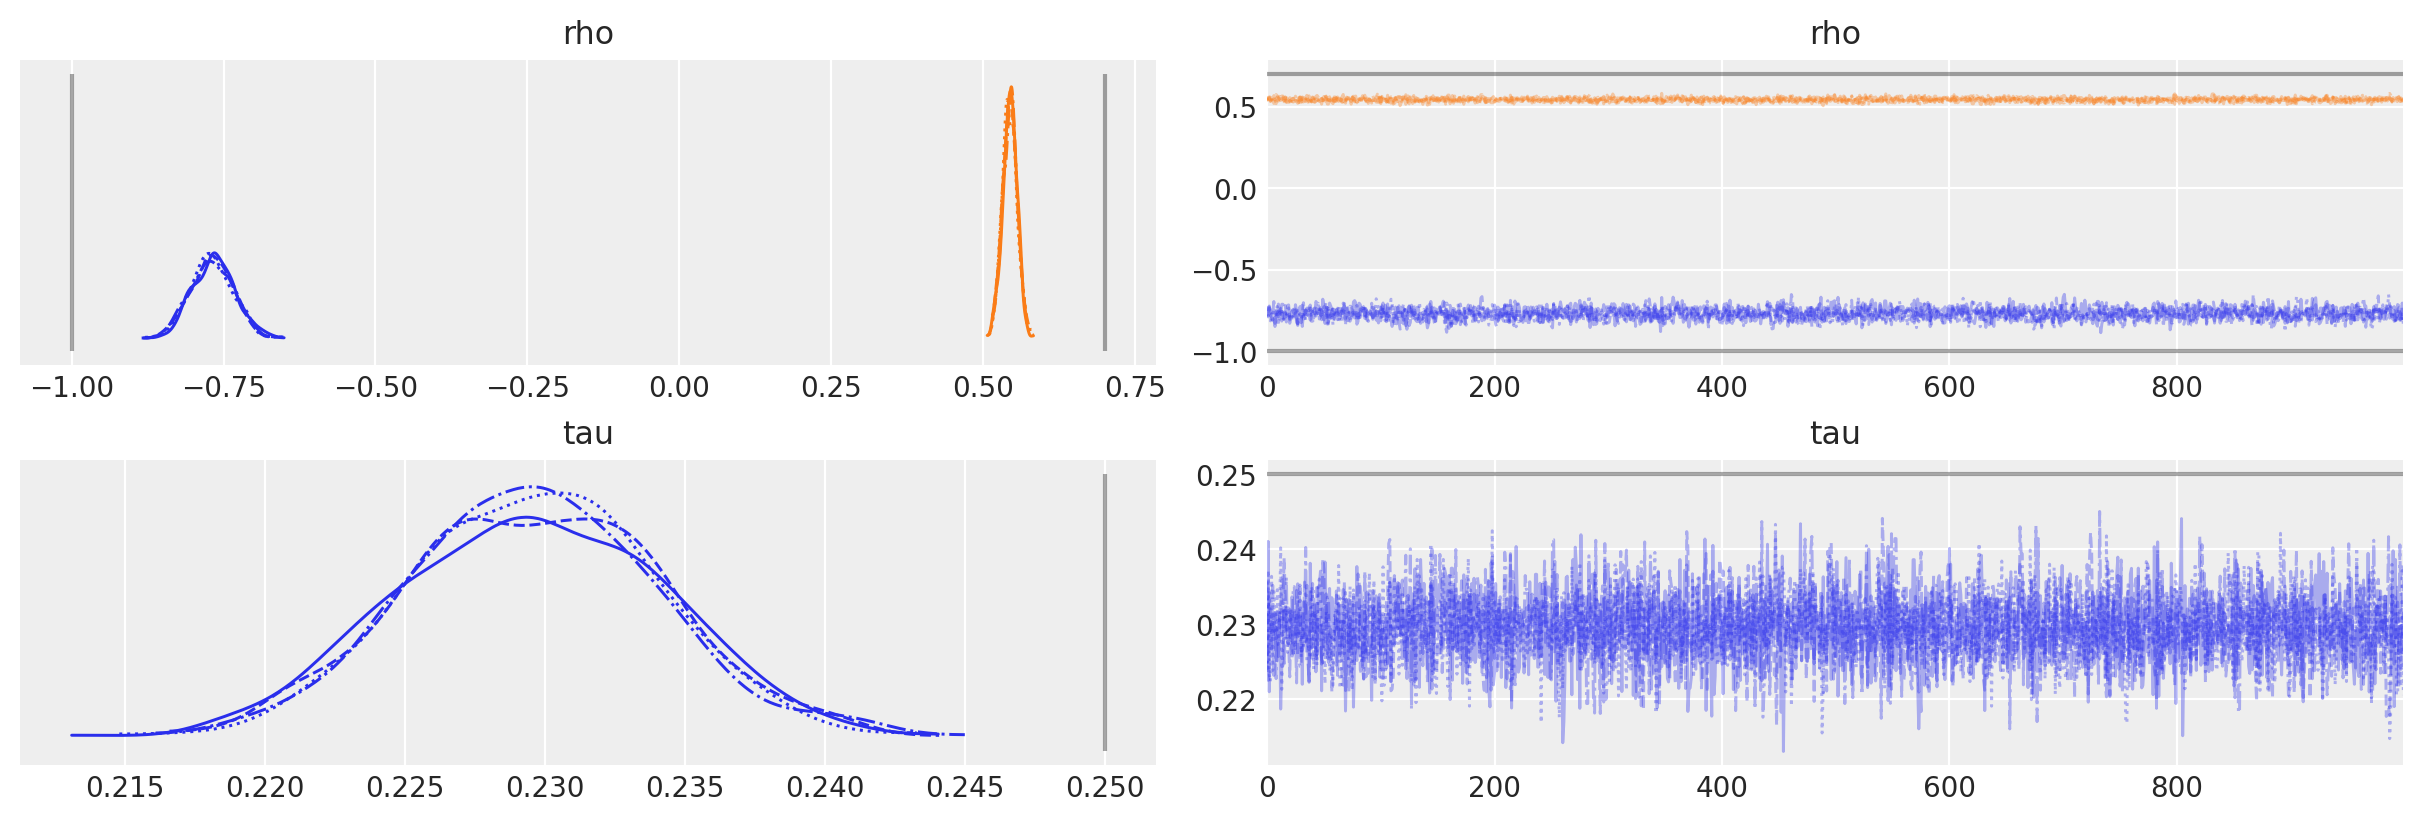

In [5]:
az.plot_trace(
    idata,
    lines=[
        ("rho", {}, [true_center, true_rho[0]]),
        ("tau", {}, true_sigma**-2),
    ],
);

## Extension to AR(p)
Now let's fit the correct underlying model, an AR(2):

$$
 y_t = \rho_0 + \rho_1 y_{t-1} + \rho_2 y_{t-2} + \epsilon_t.
$$

The `AR` distribution infers the order of the process thanks to the size the of `rho` argmument passed to `AR` (including the mean). 

We will also use the standard deviation of the innovations (rather than the precision) to parameterize the distribution.

In [6]:
with pm.Model() as ar2:
    rho = pm.Normal("rho", 0.0, 1.0, shape=3)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "y", rho=rho, sigma=sigma, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata = pm.sample(
        1000,
        tune=2000,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 9 seconds.


The posterior plots show that we have correctly inferred the generative model parameters.

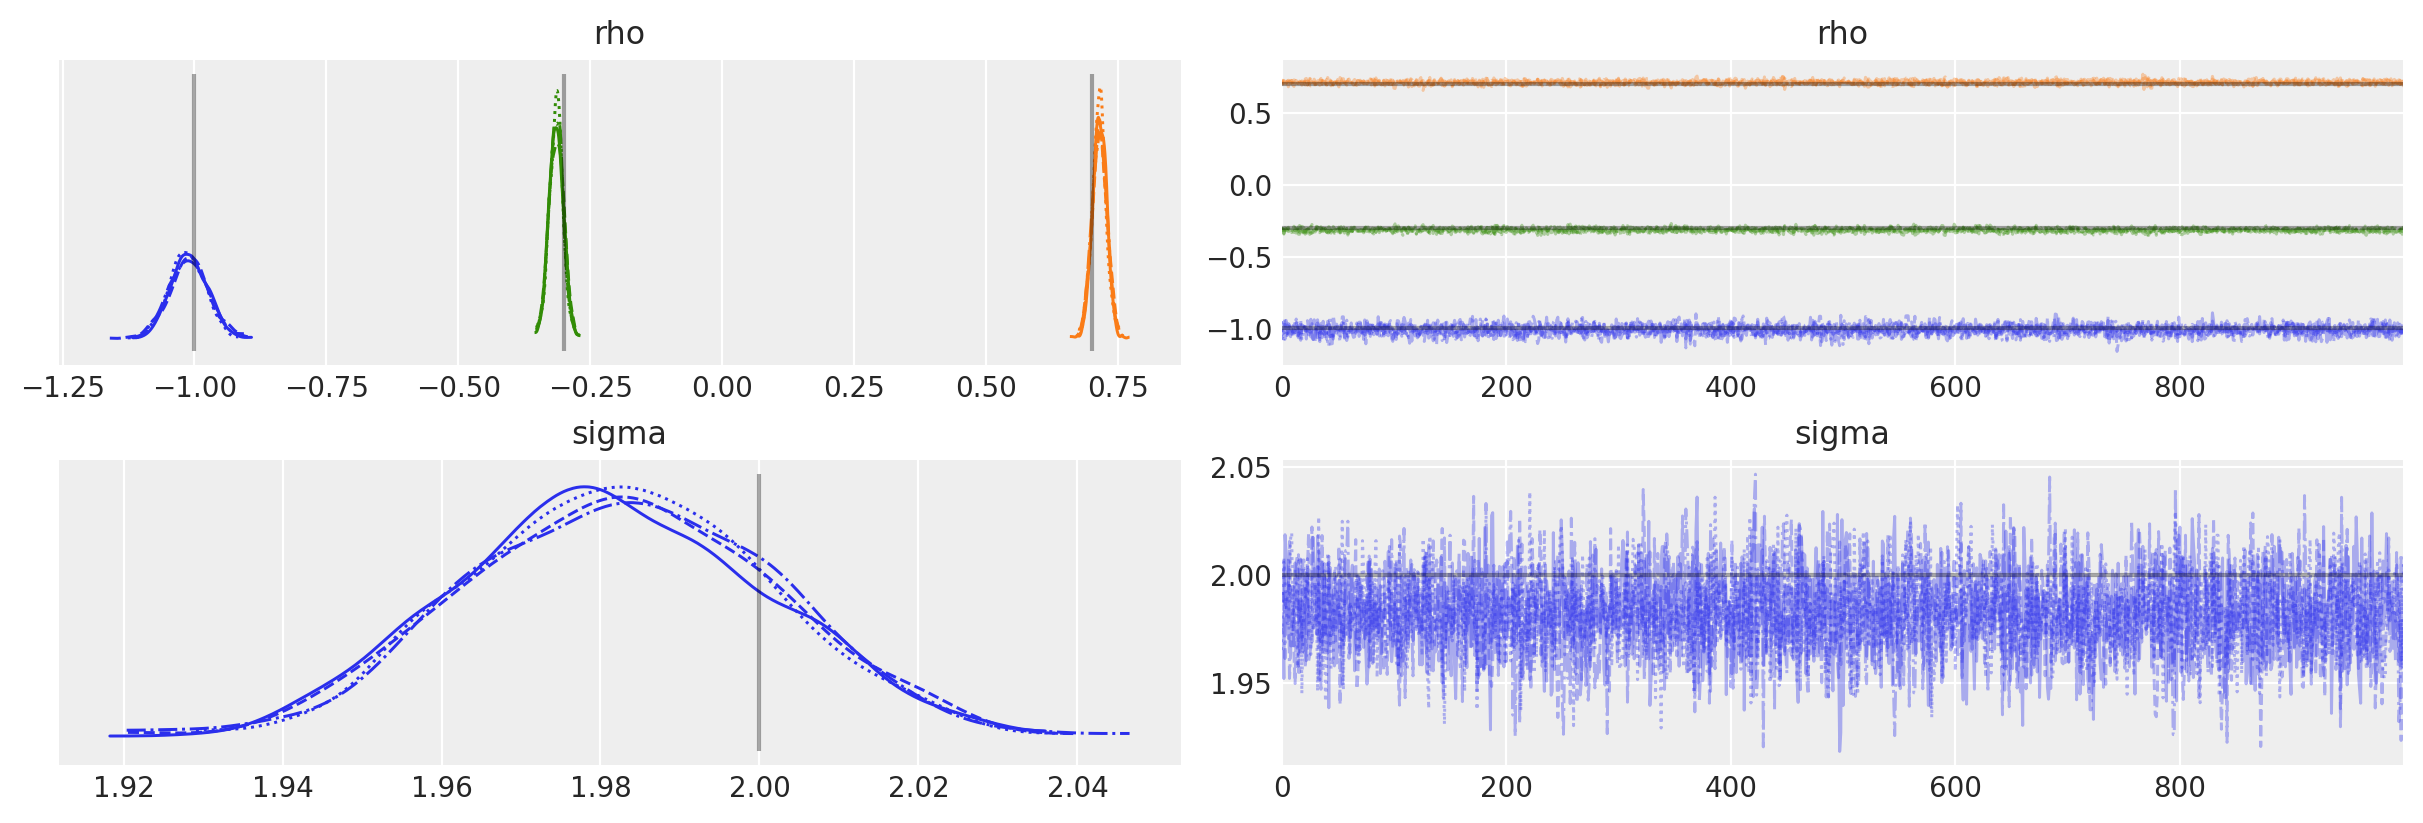

In [7]:
az.plot_trace(
    idata,
    lines=[
        ("rho", {}, (true_center,) + true_rho),
        ("sigma", {}, true_sigma),
    ],
);

You can also pass the set of AR parameters as a list, if they are not identically distributed.

In [8]:
import pytensor.tensor as pt

with pm.Model() as ar2_bis:
    rho0 = pm.Normal("rho0", mu=0.0, sigma=5.0)
    rho1 = pm.Uniform("rho1", -1, 1)
    rho2 = pm.Uniform("rho2", -1, 1)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "y",
        rho=pt.stack([rho0, rho1, rho2]),
        sigma=sigma,
        constant=True,
        init_dist=pm.Normal.dist(0, 10),
        observed=y,
    )

    idata = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho0, rho1, rho2, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 10 seconds.


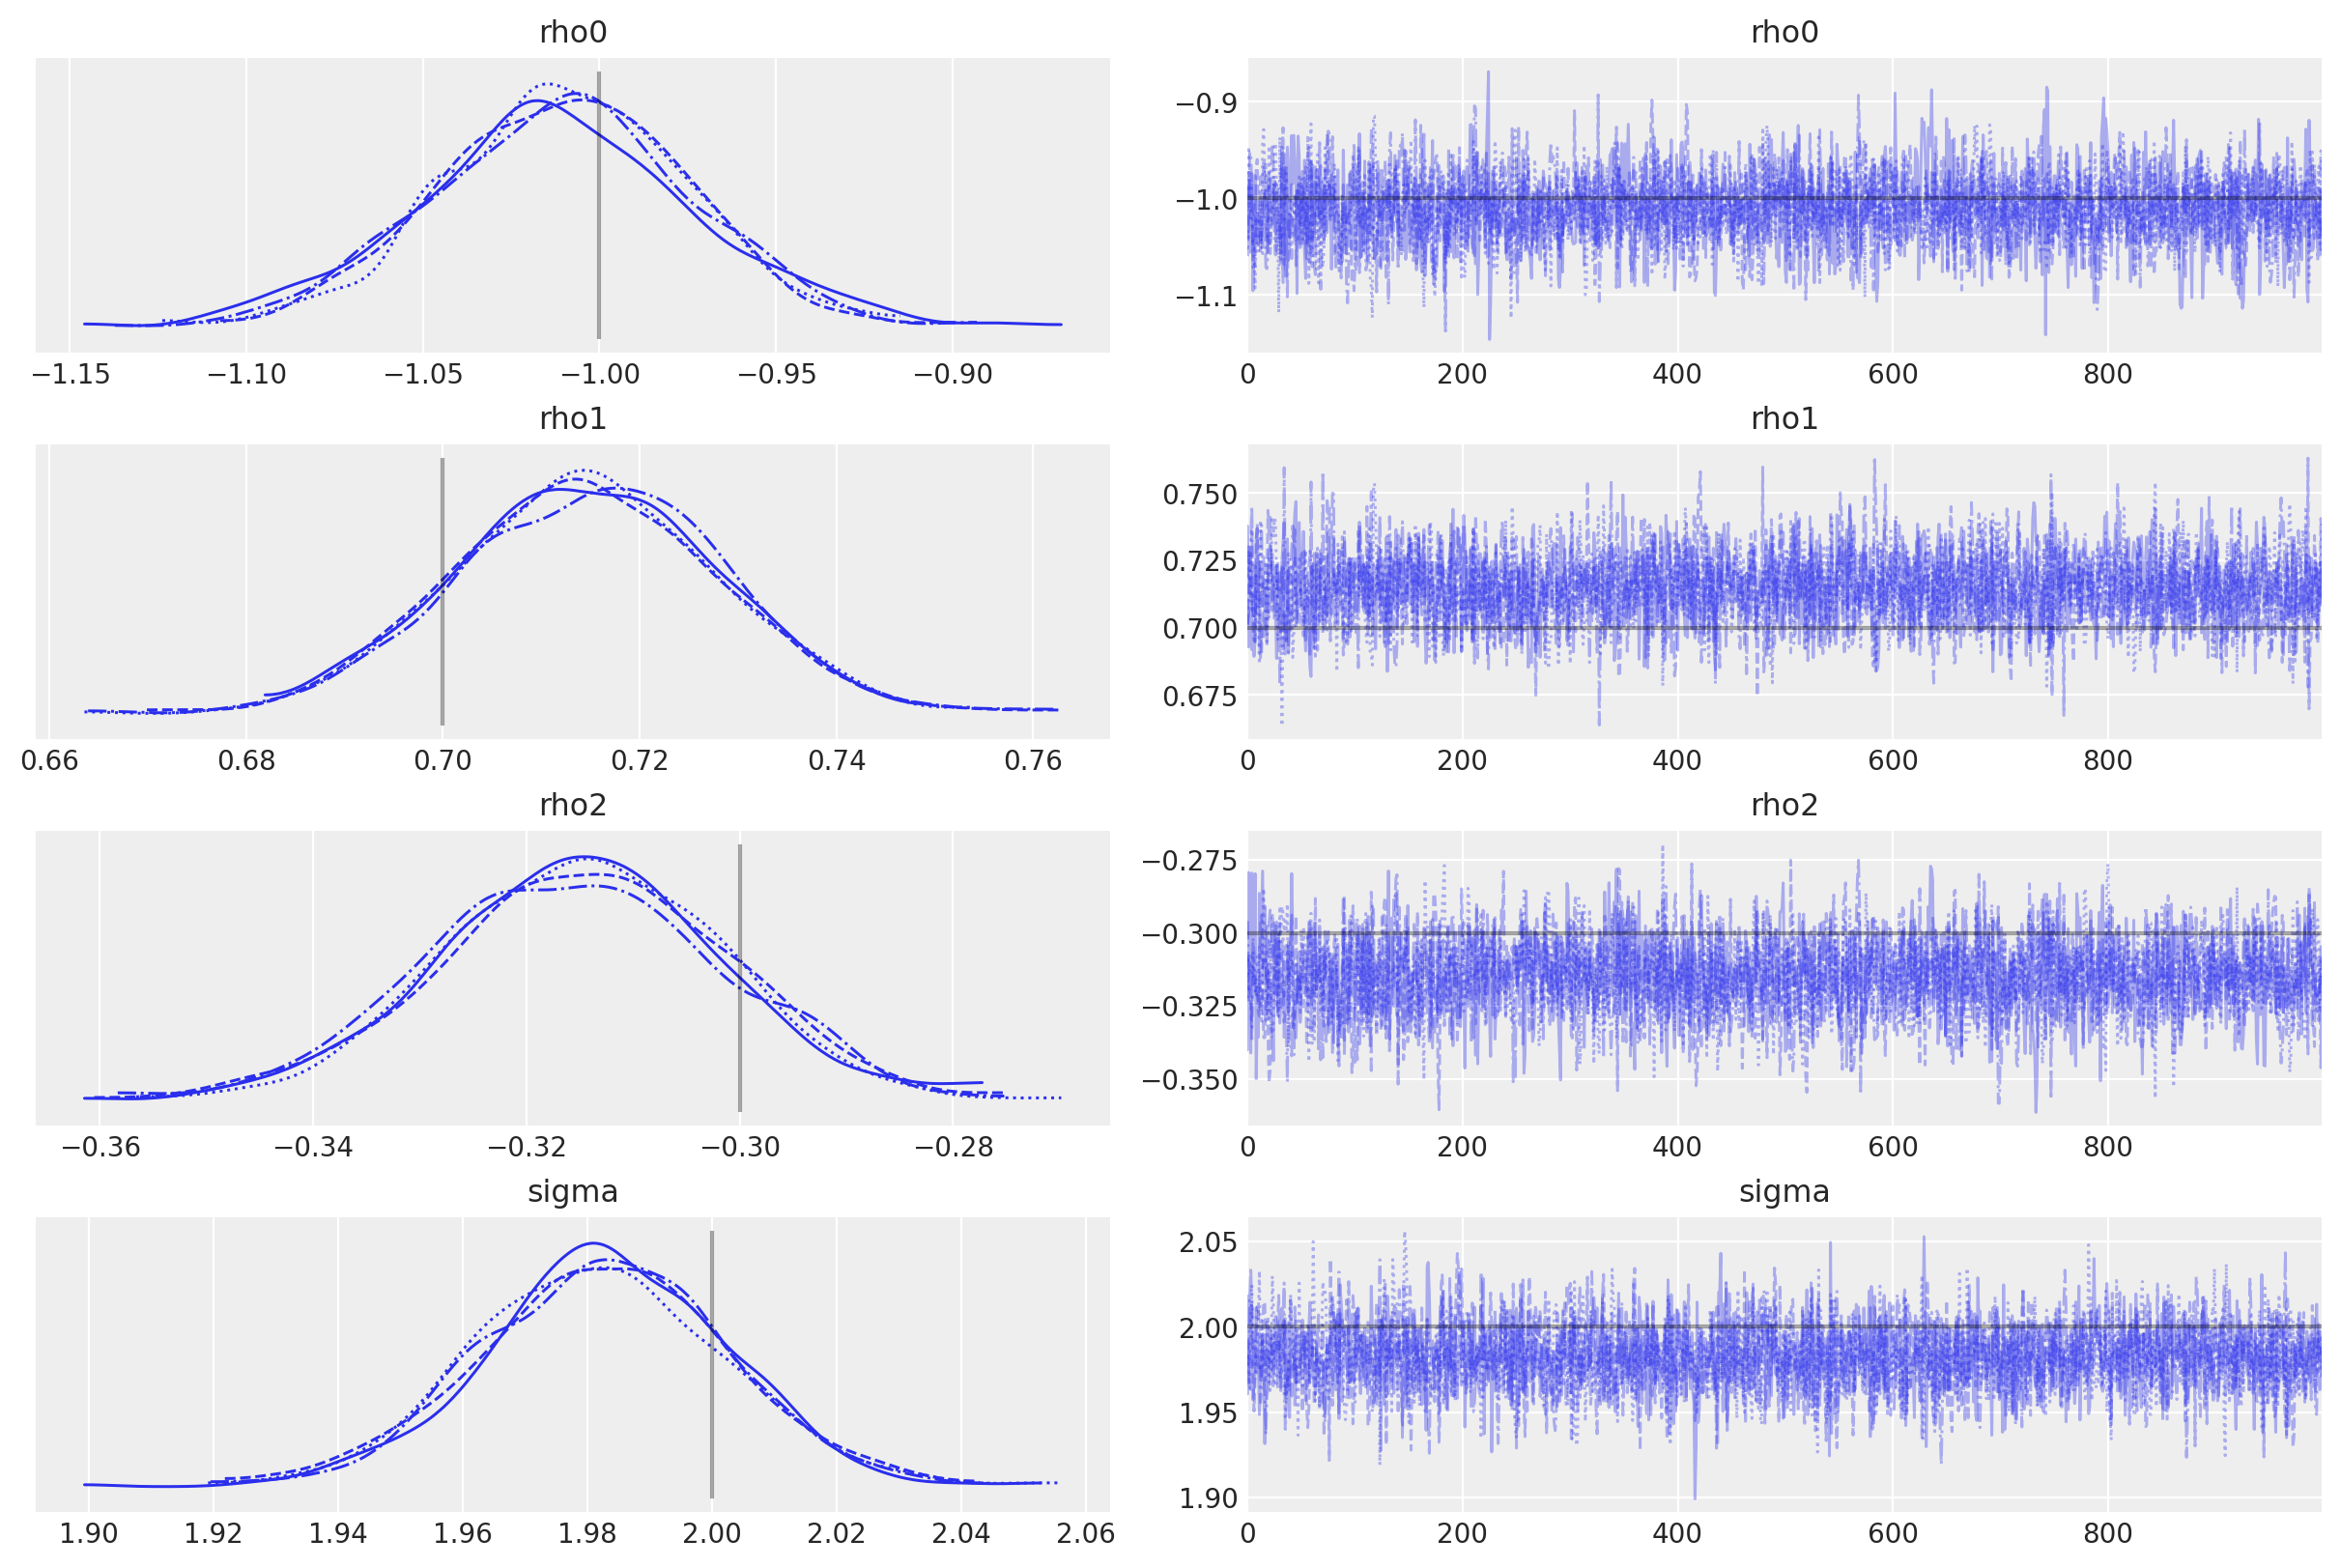

In [9]:
az.plot_trace(
    idata,
    lines=[
        ("rho0", {}, true_center),
        ("rho1", {}, true_rho[0]),
        ("rho2", {}, true_rho[1]),
        ("sigma", {}, true_sigma),
    ],
);

## Authors
* authored by Ed Herbst in August, 2016 ([pymc#1546](https://github.com/pymc-devs/pymc/pull/2285))
* updated Chris Fonnesbeck in January, 2023 ([pymc-examples#493](https://github.com/pymc-devs/pymc-examples/pull/494))

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Sat Jan 07 2023

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.7.0

pytensor: 2.8.11
aeppl   : not installed
xarray  : 2022.12.0

sys       : 3.9.0 | packaged by conda-forge | (default, Nov 26 2020, 07:57:39) 
[GCC 9.3.0]
pymc      : 5.0.1
arviz     : 0.14.0
pytensor  : 2.8.11
numpy     : 1.23.5
matplotlib: 3.6.2

Watermark: 2.3.1



:::{include} ../page_footer.md
:::